In [ ]:
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
## make plots bigger
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# models
from tbats import TBATS
from prophet import Prophet
from pmdarima import auto_arima


def plot_results(y_to_train,
                 y_to_test, y_forecast,
                 plot_conf_int=True,
                 left_bound=None, right_bound=None):

    plt.plot(y_to_train, label='train')
    plt.plot(y_to_test, label='test')
    plt.plot(y_to_test.index, y_forecast, label='prediction')

    if plot_conf_int:
        plt.fill_between(y_to_test.index,
                         left_bound, right_bound,
                         alpha=0.23, color='grey',
                         label='intervals')
    plt.legend()
    plt.show()

## Prophet, SARIMAX, TBATS — модели для предсказания временных рядов

### 1. Задача

Рассмотрим [датасет](https://www.kaggle.com/c/demand-forecasting-kernels-only/overview) с Kaggle с соревнования по прогнозированию спроса на товары.

In [ ]:
data = pd.read_csv('train.csv', parse_dates=['date'])
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
store, item = 1,1
data = data[(data['store'] == store) & (data['item'] == item)]
data = data.set_index('date')
data = data['sales']

In [ ]:
data

date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
              ..
2017-12-27    14
2017-12-28    19
2017-12-29    15
2017-12-30    27
2017-12-31    23
Name: sales, Length: 1826, dtype: int64

### 2. Данные
Разделим данные на train и test. test — данные за последний год.

In [ ]:
test_size = 365
data_train = data.iloc[: -test_size]
data_test  = data.iloc[-test_size:]

Визуализируем данные.

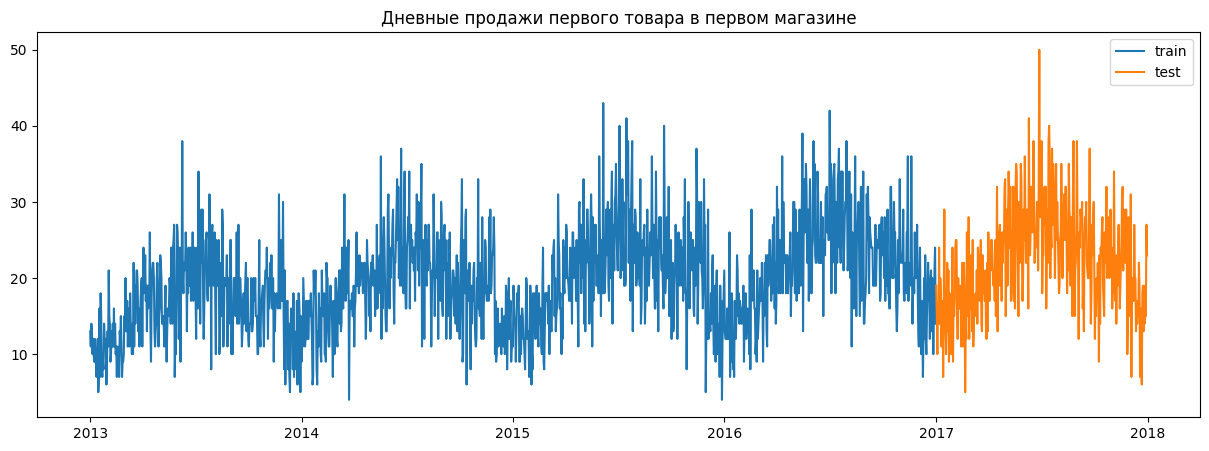

In [ ]:
plt.figure(figsize=(15, 5))

plt.title('Дневные продажи первого товара в первом магазине')

plt.plot(data_train, label='train')
plt.plot(data_test, label='test')
plt.legend()

Некоторая недельная сезонность есть.

### 3. Метрики
Зададим метрики качества моделей: MSE, MAE, MAPE. Зададим функцию, которая будет вычислять метрики качества моделей и записывать их в таблицу.

Формула для вычисления метрики **MAPE**:

![image.png](attachment:image.png)

In [ ]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred) -> float:
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [ ]:
def add_method_comparison(method: str, y_true, y_forecast, compare_table=None) -> pd.DataFrame:
    result_row = {
        'method': method,
        "MSE": mean_squared_error(y_true=y_true, y_pred=y_forecast),
        "MAE": mean_absolute_error(y_true=y_true, y_pred=y_forecast),
        "MAPE": mean_absolute_percentage_error(y_true=y_true, y_pred=y_forecast)
    }

    if compare_table is None:
        compare_table = pd.DataFrame([result_row])
    else:
        if method in list(compare_table['method']):
            compare_table = compare_table[compare_table['method'] != method]

        compare_table = pd.concat([compare_table, pd.DataFrame([result_row])])
        compare_table.index = np.arange(len(compare_table))
    return compare_table



### 4.1. Prophet

Prophet — модель, разработанная Facebook (запрещён на территории РФ) для предсказания временных рядов.

In [ ]:
prophet_train_df = pd.DataFrame(data_train)

prophet_train_df.columns = ['y']
prophet_train_df['ds'] = prophet_train_df.index

In [ ]:
prophet_train_df

,y,ds
date,,
2013-01-01,13,2013-01-01
2013-01-02,11,2013-01-02
2013-01-03,14,2013-01-03
2013-01-04,13,2013-01-04
2013-01-05,10,2013-01-05
...,...,...
2016-12-27,10,2016-12-27
2016-12-28,16,2016-12-28
2016-12-29,21,2016-12-29


In [ ]:
prophet_model = Prophet(interval_width=0.95)
prophet_model.fit(prophet_train_df)

future = prophet_model.make_future_dataframe(
    periods=test_size, include_history=False
)

y_prophet_forecast = prophet_model.predict(future)

17:48:56 - cmdstanpy - INFO - Chain [1] start processing
17:48:57 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
y_prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,22.655334,12.458853,29.320670,22.655334,22.655334,-1.504652,-1.504652,-1.504652,3.723695,3.723695,3.723695,-5.228347,-5.228347,-5.228347,0.0,0.0,0.0,21.150682
1,2017-01-02,22.659383,4.840516,21.852141,22.659383,22.659383,-9.438402,-9.438402,-9.438402,-4.232830,-4.232830,-4.232830,-5.205571,-5.205571,-5.205571,0.0,0.0,0.0,13.220981
2,2017-01-03,22.663432,7.480194,24.079039,22.663428,22.663432,-6.835870,-6.835870,-6.835870,-1.635981,-1.635981,-1.635981,-5.199889,-5.199889,-5.199889,0.0,0.0,0.0,15.827562
3,2017-01-04,22.667480,8.008681,25.212847,22.667442,22.667493,-6.324686,-6.324686,-6.324686,-1.114474,-1.114474,-1.114474,-5.210212,-5.210212,-5.210212,0.0,0.0,0.0,16.342794
4,2017-01-05,22.671529,8.464336,25.283061,22.671431,22.671552,-5.942753,-5.942753,-5.942753,-0.707771,-0.707771,-0.707771,-5.234982,-5.234982,-5.234982,0.0,0.0,0.0,16.728776


Модель для каждой даты раскладывает своё предсказание на компоненты.

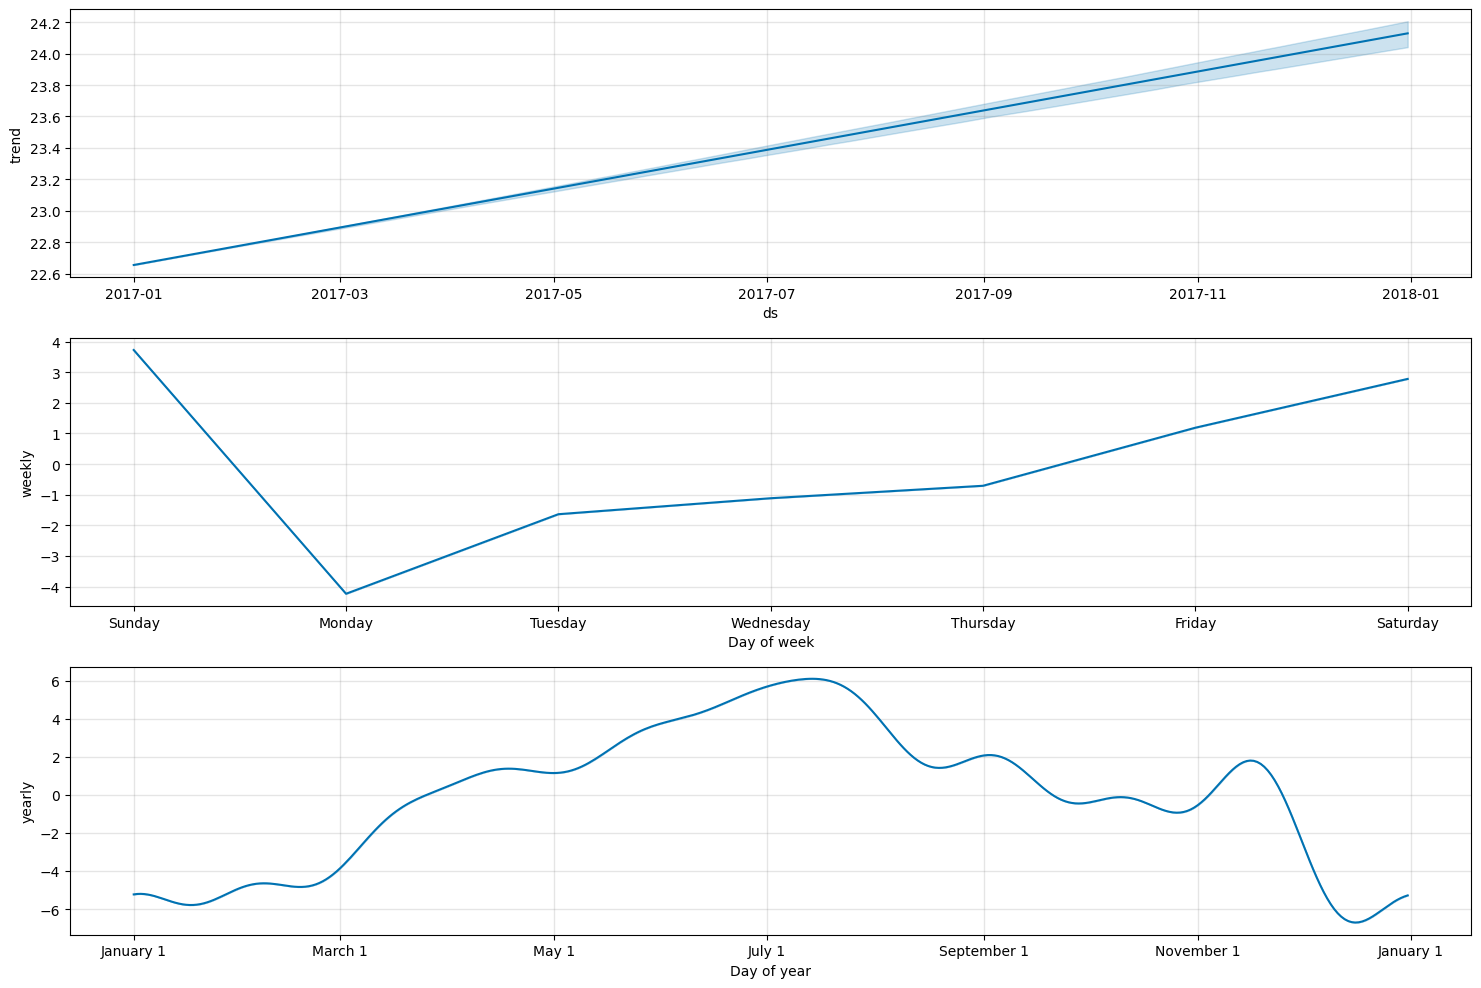

In [ ]:
prophet_model.plot_components(y_prophet_forecast, figsize=(15, 10))
plt.show()

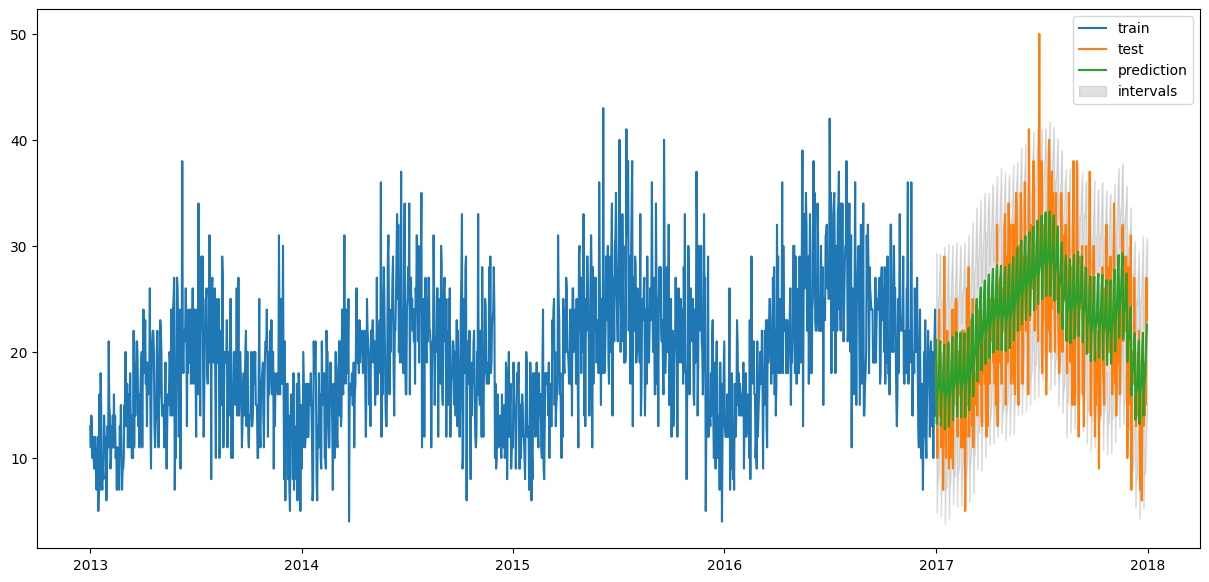

In [ ]:
plot_results(data_train, data_test, y_prophet_forecast['yhat'], plot_conf_int=True,
             left_bound=y_prophet_forecast['yhat_lower'],
             right_bound=y_prophet_forecast['yhat_upper'])

In [ ]:
compare_table = add_method_comparison('Prophet', data_test, y_prophet_forecast['yhat'])
compare_table

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153


#### Что нужно попробовать вам
- Prophet + US holidays.
- Prophet. Преобразование Бокса — Кокса:
    - сделать прямое преобразование над таргетом sps.boxcox(y);
    - потом сделать обратное (нужно написать самим).

### 4.2. Prophet + US holidays

In [ ]:
#todo

### 4.3. Prophet. Преобразование Бокса — Кокса

In [ ]:
#todo

### 5. AutoARIMA [without exog]

In [ ]:
arima_model = auto_arima(data_train, seasonal=True, m = 7)

In [ ]:
y_arima_forecast, conf_int = arima_model.predict(n_periods=test_size, return_conf_int=True, alpha=0.05)

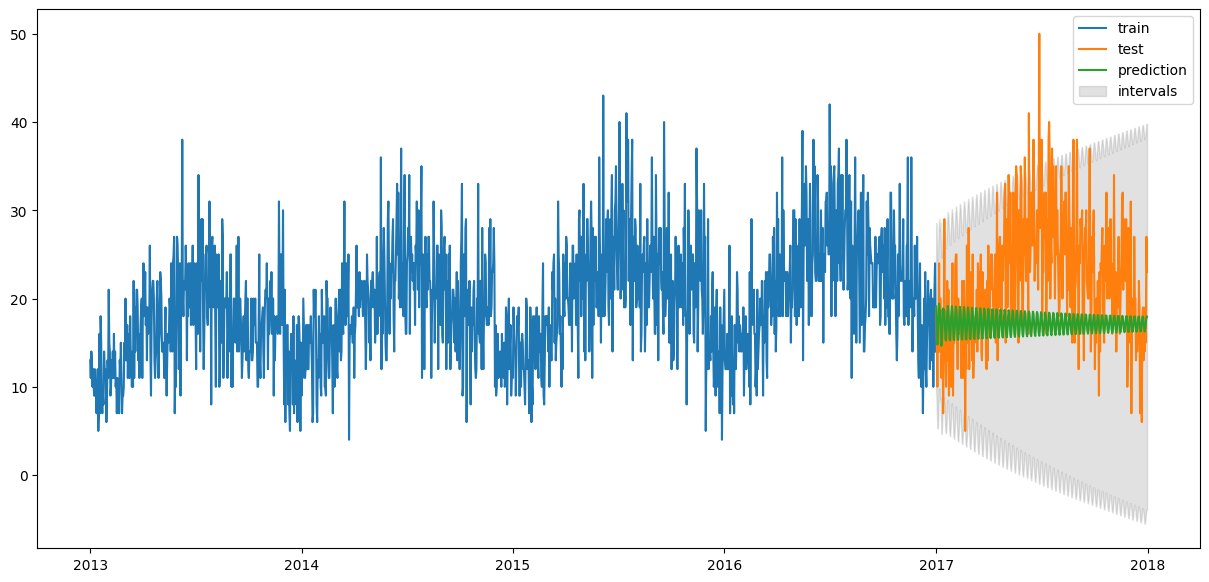

In [ ]:
plot_results(data_train, data_test, y_arima_forecast, plot_conf_int=True,
             left_bound=conf_int.T[0],
             right_bound=conf_int.T[1])

In [ ]:
compare_table = add_method_comparison('Auto arima model', data_test, y_arima_forecast, compare_table)
compare_table

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Auto arima model,70.766175,6.641262,28.894200


### 6. AutoARIMA exog

In [ ]:
exog = pd.DataFrame({'date': data.index})
exog = exog.set_index(exog['date'])

exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)

exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)

exog = exog.drop(columns=['date'])

exog_to_train = exog.iloc[:-test_size]
exog_to_test = exog.iloc[-test_size:]

todo: используйте модель `auto_arima` с экзогенными переменными, которые созданы выше (их не надо менять).

### 7.1. SARIMAX [without exog]

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# передаем параметры из прошлой модели
real_sarimax_model = SARIMAX(data_train, order=(3, 1, 5), seasonal_order=(0, 0, 2, 7),
    seasonal_periods=7,
    ).fit()


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04153D+00    |proj g|=  9.03353D-02

At iterate    5    f=  3.03248D+00    |proj g|=  2.12893D-02

At iterate   10    f=  3.03083D+00    |proj g|=  1.68000D-03

At iterate   15    f=  3.02982D+00    |proj g|=  5.12593D-02

At iterate   20    f=  3.02735D+00    |proj g|=  5.36306D-03



At iterate   25    f=  3.02555D+00    |proj g|=  6.73030D-02

At iterate   30    f=  3.01767D+00    |proj g|=  3.79465D-02

At iterate   35    f=  3.01183D+00    |proj g|=  3.85218D-01

At iterate   40    f=  3.00163D+00    |proj g|=  1.84942D-01

At iterate   45    f=  2.99775D+00    |proj g|=  1.91284D-01


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.99563D+00    |proj g|=  3.50949D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     75      1     0     0   3.509D-01   2.996D+00
  F =   2.9956281574795196     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [ ]:
forecast = real_sarimax_model.get_forecast(steps=len(data_test))
y_sarimax_real_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()


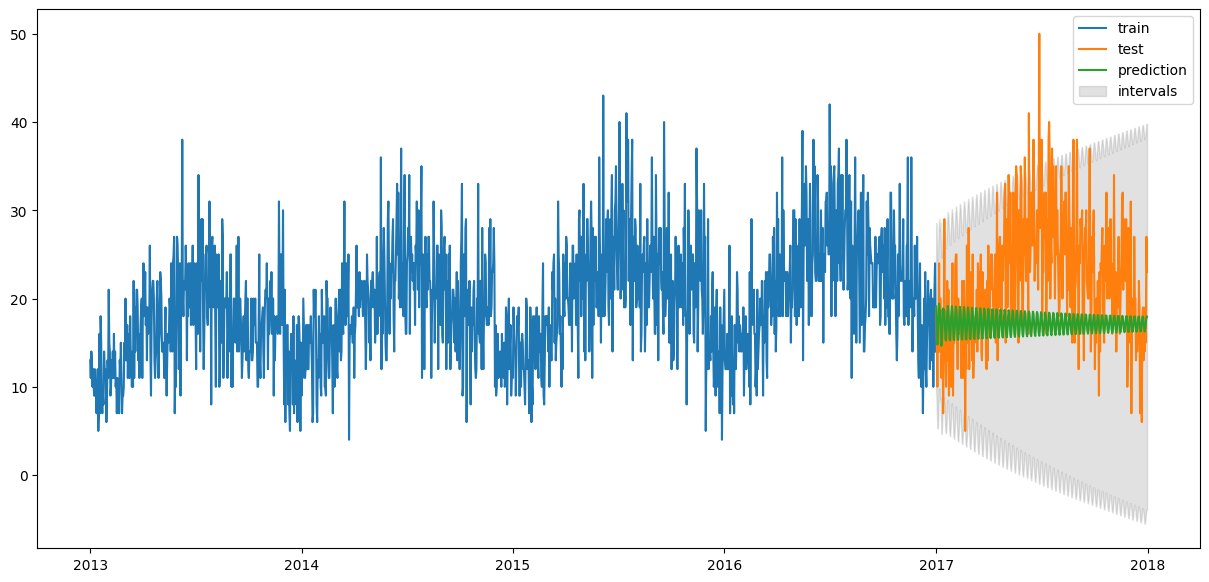

In [ ]:
plot_results(data_train, data_test,
             y_sarimax_real_forecast, plot_conf_int=True,
             left_bound=conf_int['lower sales'], right_bound=conf_int['upper sales'])

In [ ]:
compare_table = add_method_comparison('Original SARIMAX', data_test, y_sarimax_real_forecast, compare_table)
compare_table

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Auto arima model,70.766175,6.641262,28.894200
2,Original SARIMAX,70.766175,6.641262,28.894200


### 7.2. SARIMAX with exog

In [ ]:
exog = pd.DataFrame({'date': data.index})
exog = exog.set_index(exog['date'])

exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)

exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)

exog = exog.drop(columns=['date'])

exog_to_train = exog.iloc[:-test_size]
exog_to_test = exog.iloc[-test_size:]

todo: для улучшения предсказаний используйте модель `SARIMAX` с экзогенными переменными, которые созданы выше (их не надо менять).

### 8. TBATS

Модель учитывает несколько сезонностей, но не может принимать экзогенные признаки.

In [ ]:
tbats_estimator = TBATS(seasonal_periods=(7,180))
model = tbats_estimator.fit(data_train)

In [ ]:
print(model.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7. 180.]
Seasonal harmonics [3 3]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.099254
Seasonal Parameters (Gamma): [ 0.00073066  0.00126936 -0.00168366 -0.00071583]
AR coefficients []
MA coefficients []
Seed vector [11.64783078 -2.63361686 -0.19728629  1.19371923 -0.73577877  1.77368199
  0.93247816  0.28014787 -0.22456824 -0.7175311  -0.93148604 -0.02311377
  0.1540708 ]

AIC 15098.062708


In [ ]:
tbats_forecast, confidence_info = model.forecast(steps=365, confidence_level=0.95)

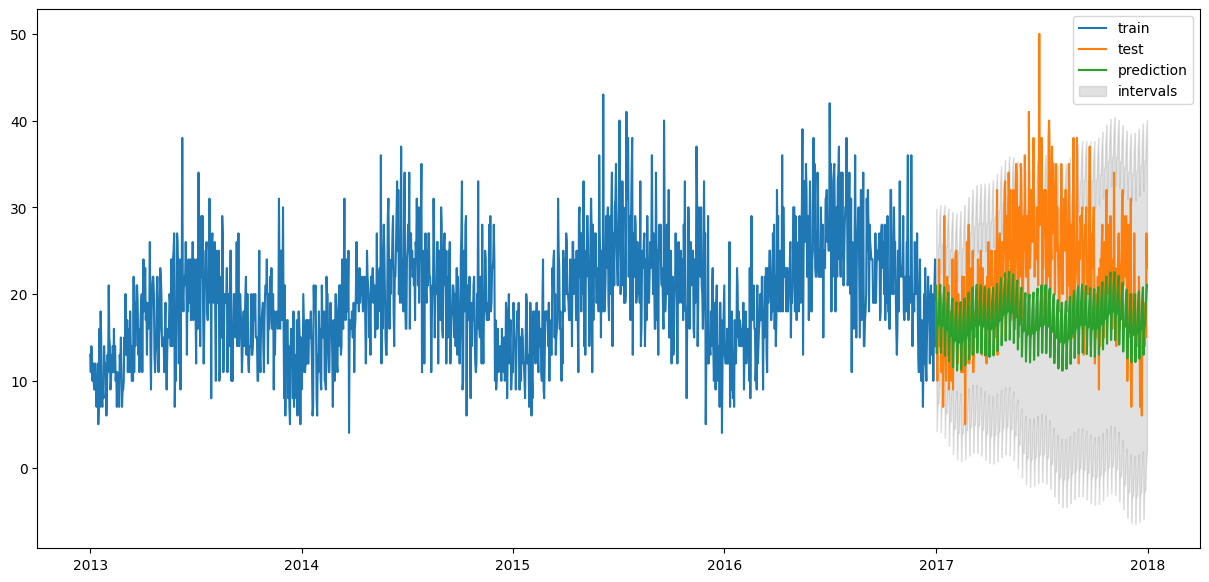

In [ ]:
plot_results(data_train, data_test, tbats_forecast, plot_conf_int=True,
             left_bound=confidence_info['lower_bound'],
             right_bound=confidence_info['upper_bound'])

In [ ]:
final_table = add_method_comparison('TBATS model', data_test, tbats_forecast, compare_table)

In [ ]:
final_table

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Auto arima model,70.766175,6.641262,28.894200
2,Original SARIMAX,70.766175,6.641262,28.894200
3,TBATS model,64.837640,6.335522,27.126855


### 9. Итого

todo:
- Опишите, что вы сделали в данной работе, какие параметры моделей подбирали и как.
- Сравните модели между собой и проанализируйте результаты.
- Выберите лучшую модель.

Метрика MAPE, которой можно достичь (достаточно правильной настройки гиперпараметров моделей), — менее 20%.

In [ ]:
final_table

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Auto arima model,70.766175,6.641262,28.894200
2,Original SARIMAX,70.766175,6.641262,28.894200
3,TBATS model,64.837640,6.335522,27.126855
